In [1]:
# Saving and type checking
import shutil
import typing
# Solving
import dolfinx
from dolfinx import mesh, fem, io, nls
from dolfinx.fem import FunctionSpace, VectorFunctionSpace
from mpi4py import MPI
import numpy as np

# Operators
import ufl
from ufl import TrialFunction, TestFunction, TrialFunctions, TestFunctions
from ufl import FacetNormal, SpatialCoordinate, variable
from ufl import diff as D
from ufl import nabla_div, nabla_grad, grad, div
from ufl import as_matrix as matrix
from ufl import lhs, rhs, split
from ufl import exp, sym, tr, sqrt, ln, sin, cos
# Graphics
import matplotlib.pyplot as plt
# Logging
from tqdm import tqdm

from local_fenics.fenics import *

In [2]:
N = 50
Nt = 100
T = 0.5
dt = T / Nt
domain = mesh.create_rectangle(
    comm=MPI.COMM_WORLD,
    points=[[-1, -1], [1, 1]],
    n=(N, N),    
    )
create_connectivity(domain=domain)
V = FunctionSpace(domain, ('CG', 1))

u, v = TrialFunction(V), TestFunction(V)
x, y = SpatialCoordinate(V)
ds = ufl.Measure("ds", domain=domain)
dx = ufl.Measure('cell', subdomain_id='everywhere')

f = Constant(V, 0)
uD = Constant(V, 0)

uS = Function(V, exp(-10 * (x**2 + y**2)))

u0 = Function(V,uS)
u_start = Function(V,uS)

uS = Function(V, u0)
bcs = [
    DirichletBC(
        space=V,
        form=uD,
        combined_marker='All',
        ),
    ]

F = (1/dt) * (u-u0) * v * dx + (grad(u)|dot|grad(v)) * dx - f*v*dx

In [3]:
problem = LinearProblem(
    lhs(F),
    rhs(F),
    bcs,
    assemble_options={
        'assemble_A': True, 'assemble_b': False
        },
    petsc_options={
        'ksp_type': 'preonly',
        'pc_type': 'lu',
        },
    )

In [4]:
try:
    shutil.rmtree('/home/FEniCSxTutorial/A_plots/Heat_Files')
except:
    print('Directory empty yet')
with io.XDMFFile(domain.comm, '/home/FEniCSxTutorial/A_plots/Heat_Files/heat.xdmf', 'w') as file:
    file.write_mesh(domain)
    for t in tqdm(np.arange(0, T, dt)):
        problem.assemble_b()
        uS = problem.solve()
        u0.interpolate(uS)
        file.write_function(uS, t)

100%|██████████| 100/100 [00:00<00:00, 100.76it/s]


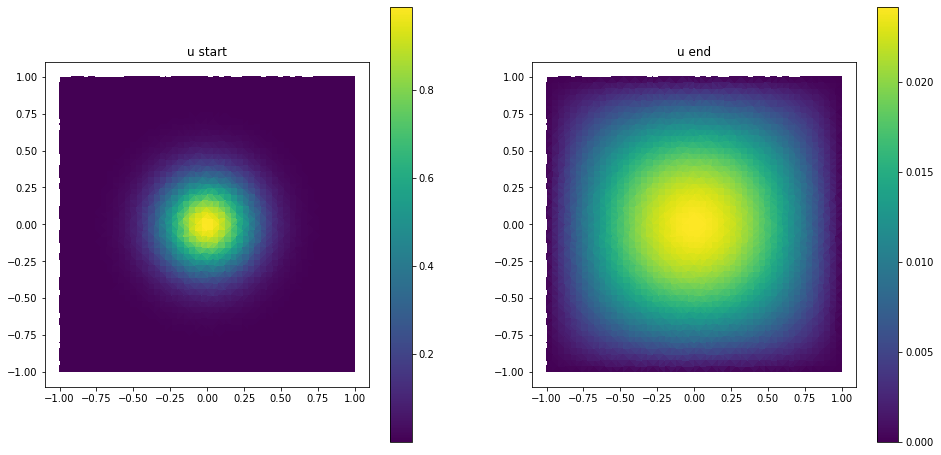

In [5]:
fig, (ax, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
PostProcess.graph2D(
    fig=fig,
    lists=[
        [u_start, ax, 'u start'],
        [uS, ax2, 'u end'],
        ],
    natural_show=True,     # points_on=True,
    )